In [84]:
import logging

import numpy as np

from tinygrad import Tensor, dtypes
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import functools
import matplotlib.pyplot as plt
import numpy as np

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [85]:
from tinygrad import Device
Device.DEFAULT = "GPU"

In [86]:
# Definition for left and right screws.
tetracubes = np.array([
  # Line.
  [ [ -1.50,  0.00,  0.00 ], [ -0.50,  0.00,  0.00 ],
    [  0.50,  0.00,  0.00 ], [  1.50,  0.00,  0.00 ] ],
  # Square.
  [ [ -0.50, -0.50,  0.00 ], [ -0.50,  0.50,  0.00 ],
    [  0.50,  0.50,  0.00 ], [  0.50, -0.50,  0.00 ] ],
  # S/Z-shape.
  [ [ -1.00,  0.50,  0.00 ], [  0.00,  0.50,  0.00 ],
    [  0.00, -0.50,  0.00 ], [  1.00, -0.50,  0.00 ] ],
  # L/J-shape.
  [ [ -0.75, -0.75,  0.00 ], [ -0.75,  0.25,  0.00 ],
    [  0.25,  0.25,  0.00 ], [  1.25,  0.25,  0.00 ] ],
  # T-shape.
  [ [ -1.00,  0.25,  0.00 ], [  0.00,  0.25,  0.00 ],
    [  1.00,  0.25,  0.00 ], [  0.00, -0.75,  0.00 ] ],
  # Corner.
  [ [ -0.75,  0.25, -0.25 ], [  0.25,  0.25, -0.25 ],
    [  0.25, -0.75, -0.25 ], [  0.25,  0.25,  0.75 ] ],
  # Right screw.
  [ [ -0.50,  0.25, -0.25 ], [ -0.50,  0.25,  0.75 ],
    [  0.50,  0.25, -0.25 ], [  0.50, -0.75, -0.25 ] ],
  # Left screw.
  [ [ -0.75,  0.50, -0.25 ], [  0.25, -0.50,  0.75 ],
    [  0.25,  0.50, -0.25 ], [  0.25, -0.50, -0.25 ] ],
])

In [87]:
def generate_datasets(num_train=1000, num_valid=100, noise_scale=0.05):

  # Assign a label to each tetracube.
  labels = np.arange(tetracubes.shape[0])

  # Randomly choose among the eight tetracubes to generate train and validation datasets.
  train_choice = np.random.choice(tetracubes.shape[0], size=(num_train,))
  valid_choice = np.random.choice(tetracubes.shape[0], size=(num_valid,))
  train_shapes = Tensor(np.take(tetracubes, train_choice, axis=0), dtype=dtypes.float32, requires_grad=True)
  valid_shapes = Tensor(np.take(tetracubes, valid_choice, axis=0), dtype=dtypes.float32, requires_grad=True)
  train_labels = Tensor(np.take(labels, train_choice, axis=0), dtype=dtypes.float32)
  valid_labels = Tensor(np.take(labels, valid_choice, axis=0), dtype=dtypes.float32)
  
  # Add Gaussian noise for some variety.
  train_shapes = train_shapes + noise_scale * Tensor(np.random.normal(size=train_shapes.shape), dtype=dtypes.float32)
  valid_shapes = valid_shapes + noise_scale * Tensor(np.random.normal(size=valid_shapes.shape), dtype=dtypes.float32)
  
  # Return final train and validation datasets.
  train_data = dict(shapes=train_shapes.realize(), labels=train_labels.realize())
  valid_data = dict(shapes=valid_shapes.realize(), labels=valid_labels.realize())
  return train_data, valid_data

In [119]:
from tinygrad import nn, TinyJit

class OrdinaryModel:
  features = 8
  
  def __init__(self):
      self.layers: List[Callable[[Tensor], Tensor]] = [
        nn.Linear(12, self.features), Tensor.relu, # 'x' has shape (..., features).
        nn.Linear(self.features, self.features), Tensor.relu,
        nn.Linear(self.features, tetracubes.shape[0])] 
        
  def __call__(self, shapes):  # The 'shapes' array has shape (..., 4, 3).
    # 1. Center shapes at origin (for translational invariance).
    shapes = shapes - shapes.mean(keepdim=True, axis=-2)  # 'shapes' still has shape (..., 4, 3).

    # 2. Flatten xyz coordinates (input features).
    x = shapes.reshape(*shapes.shape[:-2], -1)  # 'x' has shape (..., 4*3).

    return x.sequential(self.layers)

In [120]:
def compute_loss(logits, labels):
    loss = logits.sparse_categorical_crossentropy(labels).mean()
    return loss

def compute_accuracy(logits, labels):
    return Tensor.mean(Tensor.argmax(logits, -1) == labels)

In [121]:
@TinyJit
def train_step(model, optimizer, batch):
    logits = model(batch["shapes"])
    labels = batch["labels"]
    optimizer.zero_grad()
    loss = compute_loss(logits, labels).backward()
    optimizer.step()
    accuracy = compute_accuracy(logits, labels)
    return loss.item(), accuracy.item()

@TinyJit
def eval_step(model, batch):
    logits = model(batch["shapes"])
    labels = batch["labels"]
    loss = compute_loss(logits, labels)
    accuracy = compute_accuracy(logits=logits, labels=labels)
    return loss.item(), accuracy.item()


def train_model(
    model, train_data, valid_data, num_epochs, learning_rate, batch_size
):
    # Initialize model parameters and optimizer state.
    
    optimizer = nn.optim.Adam(nn.state.get_parameters(model), lr=learning_rate)

    # Determine the number of training steps per epoch.
    train_size = train_data["shapes"].shape[0]
    steps_per_epoch = train_size // batch_size

    # Train for 'num_epochs' epochs.
    for epoch in range(1, num_epochs + 1):
        # Draw random permutations for fetching batches from the train data.
        perms = np.random.permutation(train_size)
        perms = perms[
            : steps_per_epoch * batch_size
        ]  # Skip the last batch (if incomplete).
        perms = perms.reshape((steps_per_epoch, batch_size))
        perms = Tensor(perms, requires_grad=False)

        # Loop over all batches.
        train_loss = 0.0  # For keeping a running average of the loss.
        train_accuracy = 0.0  # For keeping a running average of the accuracy.
        for i, perm in enumerate(perms):
            batch = {k: v[perm, ...] for k, v in train_data.items()}
            loss, accuracy = train_step(
                model=model,
                optimizer=optimizer,
                batch=batch,
            )
            train_loss += (loss - train_loss) / (i + 1)
            train_accuracy += (accuracy - train_accuracy) / (i + 1)

        # Evaluate on the test set after each training epoch.
        valid_loss, valid_accuracy = eval_step(
            model=model, batch=valid_data
        )

        # Print progress.
        print(f"epoch: {epoch}")
        print(
            f"  train: loss {train_loss : 4.2f}, accuracy {train_accuracy * 100 : 6.2f}%"
        )
        print(
            f"  valid: loss {valid_loss : 4.2f}, accuracy {valid_accuracy * 100 : 6.2f}%"
        )

    # Return final model parameters.
    return nn.state.get_parameters(model)

In [122]:
# Generate train and test datasets.
train_data, valid_data = generate_datasets()

# Define training hyperparameters.
learning_rate = 0.005
num_epochs = 5
batch_size = 16

In [123]:
# Train the ordinary model.
ordinary_model = OrdinaryModel()

ordinary_params = train_model(
    model=ordinary_model,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

epoch: 1
  train: loss  1.99, accuracy  30.95%
  valid: loss  1.95, accuracy  56.00%
epoch: 2
  train: loss  1.99, accuracy  31.25%
  valid: loss  2.83, accuracy  72.00%
epoch: 3
  train: loss  1.99, accuracy  31.25%
  valid: loss  2.83, accuracy  72.00%
epoch: 4
  train: loss  1.99, accuracy  31.25%
  valid: loss  2.83, accuracy  72.00%
epoch: 5
  train: loss  1.99, accuracy  31.25%
  valid: loss  2.83, accuracy  72.00%


In [93]:
# copied from https://e3x.readthedocs.io/stable/_modules/e3x/so3/rotations.html#random_rotation

def random_rotation(
    perturbation: float = 1.0,
    num: int = 1,  # When num=1, leading dimension is automatically squeezed.
):
  r"""Samples a random :math:`3\times3` rotation matrix.

  Samples random :math:`3\times3` rotation matrices from :math:`\mathrm{SO(3)}`.
  The ``perturbation`` parameter controls how strongly random points on a sphere
  centered on the origin are perturbed by the rotation. For
  ``perturbation=1.0``, any point on the sphere is rotated to any other point on
  the sphere with equal probability. If ``perturbation<1.0``, returned rotation
  matrices are biased to identity matrices. For example, with
  ``perturbation=0.5``, a point on the sphere is rotated to any other point on
  the same hemisphere with equal probability.

  Example:
    >>> import jax
    >>> import e3x
    >>> tinye3nn.so3.random_rotation(jax.random.PRNGKey(0), perturbation=1.0)
    Array([[-0.93064284, -0.11807037,  0.34635717],
           [ 0.33270139,  0.1210826 ,  0.9352266 ],
           [-0.15236041,  0.9855955 , -0.07340252]], dtype=float32)
    >>> tinye3nn.so3.random_rotation(jax.random.PRNGKey(0), perturbation=0.0)
    Array([[1., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]], dtype=float32)

  Args:
    key: A PRNG key used as the random key.
    perturbation: A value between 0.0 and 1.0 that determines the perturbation.
    num: Number of returned rotation matrices.

  Returns:
    An Array of shape :math:`(\mathrm{num}, 3, 3)` or :math:`(3, 3)` (if num =
    1) representing random :math:`3\times3` rotation matrices.
  """
  # Check that perturbation is a meaningful value.
  if not 0.0 <= perturbation <= 1.0:
    raise ValueError(
        f'perturbation must be between 0.0 and 1.0, received {perturbation}'
    )
  # Draw random numbers and transform them.
  twopi = 2 * np.pi
  u = np.random.uniform(size=(num, 3))
  sqrt1 = np.sqrt(1 - u[..., 0])
  sqrt2 = np.sqrt(u[..., 0])
  angl1 = twopi * u[..., 1]
  angl2 = twopi * u[..., 2]
  # Construct random quaternion.
  r = sqrt1 * np.sin(angl1)
  i = sqrt1 * np.cos(angl1)
  j = sqrt2 * np.sin(angl2)
  k = sqrt2 * np.cos(angl2)
  # Perturbation (Slerp starting from identity quaternion).
  flip = r < 0  # Flip sign if r < 0 (always take the shorter route).
  r = np.where(flip, -r, r)
  i = np.where(flip, -i, i)
  j = np.where(flip, -j, j)
  k = np.where(flip, -k, k)
  phi = np.arccos(r)
  sinphi = np.sin(phi)
  # Prevent division by zero.
  zeromask = np.abs(sinphi) < 1e-9
  f1 = np.where(
      zeromask, 1 - perturbation, np.sin((1 - perturbation) * phi) / sinphi
  )
  f2 = np.where(zeromask, perturbation, np.sin(perturbation * phi) / sinphi)
  r, i, j, k = f1 + f2 * r, f2 * i, f2 * j, f2 * k
  # Construct rotation matrix.
  i2, j2, k2 = i * i, j * j, k * k
  ij, ik, jk, ir, jr, kr = i * j, i * k, j * k, i * r, j * r, k * r
  row1 = np.stack((1 - 2 * (j2 + k2), 2 * (ij - kr), 2 * (ik + jr)), axis=-1)
  row2 = np.stack((2 * (ij + kr), 1 - 2 * (i2 + k2), 2 * (jk - ir)), axis=-1)
  row3 = np.stack((2 * (ik - jr), 2 * (jk + ir), 1 - 2 * (i2 + j2)), axis=-1)
  rot = np.squeeze(np.stack((row1, row2, row3), axis=-1))
  return Tensor(rot)

In [96]:
# Determine the accuracy of the ordinary model for rotated shapes with different
# perturbation magnitudes (a perturbation of 0.0 gives identity matrices, a perturbation of 1.0 gives
# fully random rotation matrices).
perturbations = np.linspace(0.0, 1.0, num=6)
ordinary_accuracy = np.zeros(len(perturbations))

for i, perturbation in enumerate(perturbations):
  rot = random_rotation(perturbation=perturbation, num=valid_data['shapes'].shape[0])
  rotated_shapes = valid_data['shapes']@rot
  rotated_valid_data = {'shapes': rotated_shapes, 'labels': valid_data['labels']}
  _, ordinary_accuracy[i] = eval_step(ordinary_model, rotated_valid_data)


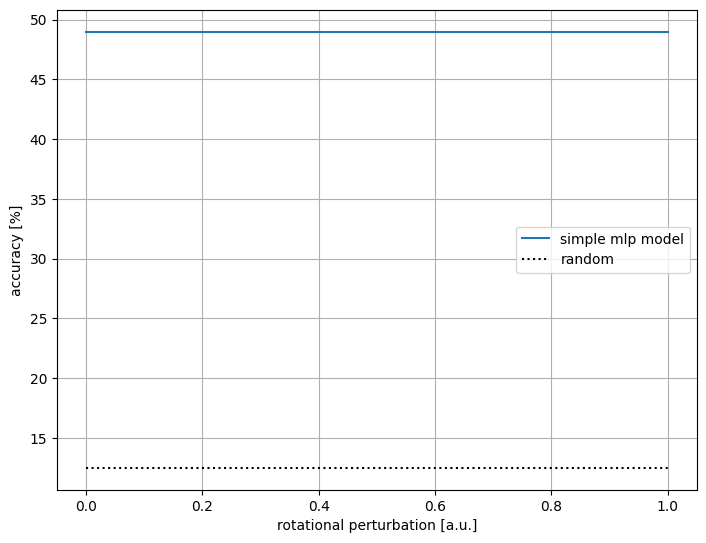

In [97]:
# Plot the results.
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('rotational perturbation [a.u.]')
plt.ylabel('accuracy [%]')
plt.plot(perturbations, ordinary_accuracy * 100, label='simple mlp model')
plt.hlines(y=100/tetracubes.shape[0], xmin=0.0, xmax=1.0, color='k', ls=':', label='random')
plt.legend(loc='center right')
plt.grid()